In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("IPL DATA SPARK PROJECT").getOrCreate()

In [0]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DateType, DecimalType, LongType
from pyspark.sql.functions import to_date
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
from pyspark.sql.functions import col, when, sum, avg, row_number, year, month, dayofmonth, lower, regexp_replace, current_date
from pyspark.sql.window import Window

In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

### Reading data

In [0]:
ball_by_ball_schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("over_id", IntegerType(), True),
    StructField("ball_id", IntegerType(), True),
    StructField("innings_no", IntegerType(), True),
    StructField("team_batting", StringType(), True),
    StructField("team_bowling", StringType(), True),
    StructField("striker_batting_position", IntegerType(), True),
    StructField("extra_type", StringType(), True),
    StructField("runs_scored", IntegerType(), True),
    StructField("extra_runs", IntegerType(), True),
    StructField("wides", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("byes", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("penalty", IntegerType(), True),
    StructField("bowler_extras", IntegerType(), True),
    StructField("out_type", StringType(), True),
    StructField("caught", BooleanType(), True),
    StructField("bowled", BooleanType(), True),
    StructField("run_out", BooleanType(), True),
    StructField("lbw", BooleanType(), True),
    StructField("retired_hurt", BooleanType(), True),
    StructField("stumped", BooleanType(), True),
    StructField("caught_and_bowled", BooleanType(), True),
    StructField("hit_wicket", BooleanType(), True),
    StructField("obstructingfeild", BooleanType(), True),
    StructField("bowler_wicket", BooleanType(), True),
    StructField("match_date", DateType(), True),
    StructField("season", IntegerType(), True),
    StructField("striker", IntegerType(), True),
    StructField("non_striker", IntegerType(), True),
    StructField("bowler", IntegerType(), True),
    StructField("player_out", IntegerType(), True),
    StructField("fielders", IntegerType(), True),
    StructField("striker_match_sk", IntegerType(), True),
    StructField("strikersk", IntegerType(), True),
    StructField("nonstriker_match_sk", IntegerType(), True),
    StructField("nonstriker_sk", IntegerType(), True),
    StructField("fielder_match_sk", IntegerType(), True),
    StructField("fielder_sk", IntegerType(), True),
    StructField("bowler_match_sk", IntegerType(), True),
    StructField("bowler_sk", IntegerType(), True),
    StructField("playerout_match_sk", IntegerType(), True),
    StructField("battingteam_sk", IntegerType(), True),
    StructField("bowlingteam_sk", IntegerType(), True),
    StructField("keeper_catch", BooleanType(), True),
    StructField("player_out_sk", IntegerType(), True),
    StructField("matchdatesk", DateType(), True)
])

In [0]:
ball_df = spark.read.schema(ball_by_ball_schema).format("csv").option("header", "true").load("s3://ipl-data-analysis-with-spark/Ball_By_Ball.csv")
ball_df.show()

+--------+-------+-------+----------+------------+------------+------------------------+----------+-----------+----------+-----+-------+----+-------+-------+-------------+--------------+------+------+-------+-----+------------+-------+-----------------+----------+----------------+-------------+----------+------+-------+-----------+------+----------+--------+----------------+---------+-------------------+-------------+----------------+----------+---------------+---------+------------------+--------------+--------------+------------+-------------+-----------+
|match_id|over_id|ball_id|innings_no|team_batting|team_bowling|striker_batting_position|extra_type|runs_scored|extra_runs|wides|legbyes|byes|noballs|penalty|bowler_extras|      out_type|caught|bowled|run_out|  lbw|retired_hurt|stumped|caught_and_bowled|hit_wicket|obstructingfeild|bowler_wicket|match_date|season|striker|non_striker|bowler|player_out|fielders|striker_match_sk|strikersk|nonstriker_match_sk|nonstriker_sk|fielder_match_s

In [0]:
match_schema = StructType([
    StructField("match_sk", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("match_date", StringType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("venue_name", StringType(), True),
    StructField("city_name", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("match_winner", StringType(), True),
    StructField("toss_name", StringType(), True),
    StructField("win_type", StringType(), True),
    StructField("outcome_type", StringType(), True),
    StructField("manofmach", StringType(), True),
    StructField("win_margin", IntegerType(), True),
    StructField("country_id", IntegerType(), True)
])
match_df = spark.read.schema(match_schema).format("csv").option("header", "true").load("s3://ipl-data-analysis-with-spark/Match.csv")
match_df.show()

+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-------------+----------+----------+
|match_sk|match_id|               team1|               team2|match_date|season_year|          venue_name| city_name|country_name|         toss_winner|        match_winner|toss_name|win_type|outcome_type|    manofmach|win_margin|country_id|
+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-------------+----------+----------+
|       0|  335987|Royal Challengers...|Kolkata Knight Ri...| 4/18/2008|       2008|M Chinnaswamy Sta...| Bangalore|       India|Royal Challengers...|Kolkata Knight Ri...|    field|    runs|      Result|  BB McCullum|       140|         1|
|       1|  335988|     Kings XI Punjab|

In [0]:

match_df = match_df.withColumn("match_date", to_date(match_df["match_date"], "M/dd/yyyy"))

In [0]:


player_match_schema = StructType([
    StructField("player_match_sk", IntegerType(), True),
    StructField("playermatch_key", DecimalType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", StringType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("role_desc", StringType(), True),
    StructField("player_team", StringType(), True),
    StructField("opposit_team", StringType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("is_manofthematch", BooleanType(), True),
    StructField("age_as_on_match", IntegerType(), True),
    StructField("isplayers_team_won", BooleanType(), True),
    StructField("batting_status", StringType(), True),
    StructField("bowling_status", StringType(), True),
    StructField("player_captain", StringType(), True),
    StructField("opposit_captain", StringType(), True),
    StructField("player_keeper", StringType(), True),
    StructField("opposit_keeper", StringType(), True)
])
player_match_df = spark.read.schema(player_match_schema).format("csv").option("header", "true").load("s3://ipl-data-analysis-with-spark/Player_match.csv")
player_match_df.show()

+---------------+---------------+--------+---------+---------------+----------+--------------+--------------------+------------+---------+--------------------+--------------------+-----------+----------------+---------------+------------------+--------------+--------------+--------------+---------------+-------------+--------------+
|player_match_sk|playermatch_key|match_id|player_id|    player_name|       dob|  batting_hand|       bowling_skill|country_name|role_desc|         player_team|        opposit_team|season_year|is_manofthematch|age_as_on_match|isplayers_team_won|batting_status|bowling_status|player_captain|opposit_captain|player_keeper|opposit_keeper|
+---------------+---------------+--------+---------+---------------+----------+--------------+--------------------+------------+---------+--------------------+--------------------+-----------+----------------+---------------+------------------+--------------+--------------+--------------+---------------+-------------+-----------

In [0]:
player_match_df = player_match_df.withColumn("dob", to_date(player_match_df["dob"], "M/dd/yyyy"))

In [0]:
player_schema = StructType([
    StructField("player_sk", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True)
])

player_df = spark.read.schema(player_schema).format("csv").option("header", "true").load("s3://ipl-data-analysis-with-spark/Player.csv")
player_df.show()

+---------+---------+---------------+----+--------------+--------------------+------------+
|player_sk|player_id|    player_name| dob|  batting_hand|       bowling_skill|country_name|
+---------+---------+---------------+----+--------------+--------------------+------------+
|        0|        1|     SC Ganguly|null| Left-hand bat|    Right-arm medium|       India|
|        1|        2|    BB McCullum|null|Right-hand bat|    Right-arm medium| New Zealand|
|        2|        3|     RT Ponting|null|Right-hand bat|    Right-arm medium|   Australia|
|        3|        4|      DJ Hussey|null|Right-hand bat|  Right-arm offbreak|   Australia|
|        4|        5|Mohammad Hafeez|null|Right-hand bat|  Right-arm offbreak|    Pakistan|
|        5|        6|       R Dravid|null|Right-hand bat|  Right-arm offbreak|       India|
|        6|        7|       W Jaffer|null|Right-hand bat|  Right-arm offbreak|       India|
|        7|        8|        V Kohli|null|Right-hand bat|    Right-arm medium|  

In [0]:
team_schema = StructType([
    StructField("team_sk", IntegerType(), True),
    StructField("team_id", IntegerType(), True),
    StructField("team_name", StringType(), True)
])
team_df = spark.read.schema(team_schema).format("csv").option("header", "true").load("s3://ipl-data-analysis-with-spark/Team.csv")
team_df.show()

+-------+-------+--------------------+
|team_sk|team_id|           team_name|
+-------+-------+--------------------+
|      0|      1|Kolkata Knight Ri...|
|      1|      2|Royal Challengers...|
|      2|      3| Chennai Super Kings|
|      3|      4|     Kings XI Punjab|
|      4|      5|    Rajasthan Royals|
|      5|      6|    Delhi Daredevils|
|      6|      7|      Mumbai Indians|
|      7|      8|     Deccan Chargers|
|      8|      9|Kochi Tuskers Kerala|
|      9|     10|       Pune Warriors|
|     10|     11| Sunrisers Hyderabad|
|     11|     12|Rising Pune Super...|
|     12|     13|       Gujarat Lions|
+-------+-------+--------------------+



### Data Transformation

##### Filter only valid balls

In [0]:
ball_df.filter("extra_runs = 0").show(5)

+--------+-------+-------+----------+------------+------------+------------------------+----------+-----------+----------+-----+-------+----+-------+-------+-------------+--------------+------+------+-------+-----+------------+-------+-----------------+----------+----------------+-------------+----------+------+-------+-----------+------+----------+--------+----------------+---------+-------------------+-------------+----------------+----------+---------------+---------+------------------+--------------+--------------+------------+-------------+-----------+
|match_id|over_id|ball_id|innings_no|team_batting|team_bowling|striker_batting_position|extra_type|runs_scored|extra_runs|wides|legbyes|byes|noballs|penalty|bowler_extras|      out_type|caught|bowled|run_out|  lbw|retired_hurt|stumped|caught_and_bowled|hit_wicket|obstructingfeild|bowler_wicket|match_date|season|striker|non_striker|bowler|player_out|fielders|striker_match_sk|strikersk|nonstriker_match_sk|nonstriker_sk|fielder_match_s

##### GroupBy match and innings

In [0]:
ball_df.groupBy("match_id", "innings_no").agg(
    sum("runs_scored").alias("sum_of_runs"),
).show()

+--------+----------+-----------+
|match_id|innings_no|sum_of_runs|
+--------+----------+-----------+
|  980940|         1|        138|
|  419132|         1|        165|
| 1082632|         2|        202|
|  335993|         2|        131|
|  980910|         2|        156|
|  598057|         2|        141|
|  980966|         1|        143|
|  980982|         2|        169|
|  419114|         2|        130|
|  734042|         2|        156|
|  829772|         2|        111|
|  501257|         2|        143|
|  548328|         2|        123|
|  392244|         1|        135|
|  336000|         1|        147|
|  548340|         1|        123|
|  419149|         1|        174|
|  336017|         2|        113|
|  392214|         2|         93|
|  548347|         2|        166|
+--------+----------+-----------+
only showing top 20 rows



##### Calculate running total of runs

In [0]:
WindowSpec = Window.partitionBy("match_id", "innings_no").orderBy("over_id", "ball_id")

ball_df.withColumn("running_total", 
                   sum("runs_scored").over(WindowSpec)).select("match_id", "innings_no", "over_id", "ball_id","runs_scored", "running_total").show()

+--------+----------+-------+-------+-----------+-------------+
|match_id|innings_no|over_id|ball_id|runs_scored|running_total|
+--------+----------+-------+-------+-----------+-------------+
|  335987|         1|      1|      1|          0|            0|
|  335987|         1|      1|      2|          0|            0|
|  335987|         1|      1|      3|          0|            0|
|  335987|         1|      1|      4|          0|            0|
|  335987|         1|      1|      5|          0|            0|
|  335987|         1|      1|      6|          0|            0|
|  335987|         1|      1|      7|          0|            0|
|  335987|         1|      2|      1|          0|            0|
|  335987|         1|      2|      2|          4|            4|
|  335987|         1|      2|      3|          4|            8|
|  335987|         1|      2|      4|          6|           14|
|  335987|         1|      2|      5|          4|           18|
|  335987|         1|      2|      6|   

##### Calculate high impact balls (either wicket or greater than 6 runs balls)

In [0]:
# basic conditions
ball_df.withColumn("is_high_impact",
        (ball_df["out_type"] != "Not Applicable") | ((ball_df["runs_scored"]+ ball_df["extra_runs"])>6)
        ).select("match_id", "innings_no", "ball_id","out_type","runs_scored","extra_runs","is_high_impact").filter("is_high_impact = true " ).show()

+--------+----------+-------+------------+-----------+----------+--------------+
|match_id|innings_no|ball_id|    out_type|runs_scored|extra_runs|is_high_impact|
+--------+----------+-------+------------+-----------+----------+--------------+
|  598028|         1|      5|Keeper Catch|          0|         0|          true|
|  598063|         2|      5|      bowled|          0|         0|          true|
|  598063|         2|      2|Keeper Catch|          0|         0|          true|
|  829720|         2|      6|      caught|          0|         0|          true|
|  829720|         2|      2|      caught|          0|         0|          true|
|  829720|         2|      6|     stumped|          0|         0|          true|
|  829720|         2|      5|         lbw|          0|         0|          true|
|  829782|         1|      5|Keeper Catch|          0|         0|          true|
|  829782|         1|      2|      caught|          0|         0|          true|
|  829774|         2|      5

In [0]:
#using case when
ball_df.withColumn("is_high_impact",
        when((ball_df["out_type"] != "Not Applicable") | ((ball_df["runs_scored"]+ ball_df["extra_runs"])>6), True).otherwise(False)
        ).select("match_id", "innings_no", "ball_id","out_type","runs_scored","extra_runs","is_high_impact").filter("is_high_impact = true" ).show()

+--------+----------+-------+------------+-----------+----------+--------------+
|match_id|innings_no|ball_id|    out_type|runs_scored|extra_runs|is_high_impact|
+--------+----------+-------+------------+-----------+----------+--------------+
|  598028|         1|      5|Keeper Catch|          0|         0|          true|
|  598063|         2|      5|      bowled|          0|         0|          true|
|  598063|         2|      2|Keeper Catch|          0|         0|          true|
|  829720|         2|      6|      caught|          0|         0|          true|
|  829720|         2|      2|      caught|          0|         0|          true|
|  829720|         2|      6|     stumped|          0|         0|          true|
|  829720|         2|      5|         lbw|          0|         0|          true|
|  829782|         1|      5|Keeper Catch|          0|         0|          true|
|  829782|         1|      2|      caught|          0|         0|          true|
|  829774|         2|      5

##### Extract year, month, date

In [0]:
match_df = match_df.withColumn("Year", 
                    year("match_date")
            )
match_df = match_df.withColumn("month", 
                    month("match_date")
            )
match_df = match_df.withColumn("day", 
                    dayofmonth("match_date")
            )

match_df.show()

+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-------------+----------+----------+----+-----+---+
|match_sk|match_id|               team1|               team2|match_date|season_year|          venue_name| city_name|country_name|         toss_winner|        match_winner|toss_name|win_type|outcome_type|    manofmach|win_margin|country_id|Year|month|day|
+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-------------+----------+----------+----+-----+---+
|       0|  335987|Royal Challengers...|Kolkata Knight Ri...|2008-04-18|       2008|M Chinnaswamy Sta...| Bangalore|       India|Royal Challengers...|Kolkata Knight Ri...|    field|    runs|      Result|  BB McCullum|       140|       

##### Determine if the win is high margin

In [0]:
match_df.withColumn("margin",
                    when(match_df["win_margin"]>=100, "High" )
                    .when((match_df["win_margin"]>50) & (match_df["win_margin"]<100), "Medium")
                    .otherwise("Low")).select("team1", "team2", "match_winner", "margin").show()

+--------------------+--------------------+--------------------+------+
|               team1|               team2|        match_winner|margin|
+--------------------+--------------------+--------------------+------+
|Royal Challengers...|Kolkata Knight Ri...|Kolkata Knight Ri...|  High|
|     Kings XI Punjab| Chennai Super Kings| Chennai Super Kings|   Low|
|    Delhi Daredevils|    Rajasthan Royals|    Delhi Daredevils|   Low|
|      Mumbai Indians|Royal Challengers...|Royal Challengers...|   Low|
|Kolkata Knight Ri...|     Deccan Chargers|Kolkata Knight Ri...|   Low|
|    Rajasthan Royals|     Kings XI Punjab|    Rajasthan Royals|   Low|
|     Deccan Chargers|    Delhi Daredevils|    Delhi Daredevils|   Low|
| Chennai Super Kings|      Mumbai Indians| Chennai Super Kings|   Low|
|     Deccan Chargers|    Rajasthan Royals|    Rajasthan Royals|   Low|
|     Kings XI Punjab|      Mumbai Indians|     Kings XI Punjab|Medium|
|Royal Challengers...|    Rajasthan Royals|    Rajasthan Royals|

##### Determine toss winner and match winner

In [0]:
match_df.withColumn("toss_match_winner",
                    match_df["toss_winner"] == match_df["match_winner"]



            ).select("toss_winner", "match_winner","toss_match_winner" ).filter("toss_match_winner= true").show()

+--------------------+--------------------+-----------------+
|         toss_winner|        match_winner|toss_match_winner|
+--------------------+--------------------+-----------------+
| Chennai Super Kings| Chennai Super Kings|             true|
|    Rajasthan Royals|    Rajasthan Royals|             true|
|    Rajasthan Royals|    Rajasthan Royals|             true|
|     Deccan Chargers|     Deccan Chargers|             true|
| Chennai Super Kings| Chennai Super Kings|             true|
|     Kings XI Punjab|     Kings XI Punjab|             true|
|    Rajasthan Royals|    Rajasthan Royals|             true|
|     Kings XI Punjab|     Kings XI Punjab|             true|
|     Kings XI Punjab|     Kings XI Punjab|             true|
|     Deccan Chargers|     Deccan Chargers|             true|
|      Mumbai Indians|      Mumbai Indians|             true|
| Chennai Super Kings| Chennai Super Kings|             true|
|Kolkata Knight Ri...|Kolkata Knight Ri...|             true|
|    Raj

##### Clean player names

In [0]:
player_df.withColumn("player_name",
                     lower(regexp_replace("player_name", "^a-zA-Z0-9 ",""))
).show()

+---------+---------+---------------+----+--------------+--------------------+------------+
|player_sk|player_id|    player_name| dob|  batting_hand|       bowling_skill|country_name|
+---------+---------+---------------+----+--------------+--------------------+------------+
|        0|        1|     sc ganguly|null| Left-hand bat|    Right-arm medium|       India|
|        1|        2|    bb mccullum|null|Right-hand bat|    Right-arm medium| New Zealand|
|        2|        3|     rt ponting|null|Right-hand bat|    Right-arm medium|   Australia|
|        3|        4|      dj hussey|null|Right-hand bat|  Right-arm offbreak|   Australia|
|        4|        5|mohammad hafeez|null|Right-hand bat|  Right-arm offbreak|    Pakistan|
|        5|        6|       r dravid|null|Right-hand bat|  Right-arm offbreak|       India|
|        6|        7|       w jaffer|null|Right-hand bat|  Right-arm offbreak|       India|
|        7|        8|        v kohli|null|Right-hand bat|    Right-arm medium|  

##### Replace null values

In [0]:
player_df.na.fill("unknown", subset=["batting_hand", "bowling_skill"]).show()

+---------+---------+---------------+----+--------------+--------------------+------------+
|player_sk|player_id|    player_name| dob|  batting_hand|       bowling_skill|country_name|
+---------+---------+---------------+----+--------------+--------------------+------------+
|        0|        1|     SC Ganguly|null| Left-hand bat|    Right-arm medium|       India|
|        1|        2|    BB McCullum|null|Right-hand bat|    Right-arm medium| New Zealand|
|        2|        3|     RT Ponting|null|Right-hand bat|    Right-arm medium|   Australia|
|        3|        4|      DJ Hussey|null|Right-hand bat|  Right-arm offbreak|   Australia|
|        4|        5|Mohammad Hafeez|null|Right-hand bat|  Right-arm offbreak|    Pakistan|
|        5|        6|       R Dravid|null|Right-hand bat|  Right-arm offbreak|       India|
|        6|        7|       W Jaffer|null|Right-hand bat|  Right-arm offbreak|       India|
|        7|        8|        V Kohli|null|Right-hand bat|    Right-arm medium|  

In [0]:
player_match_df.withColumn("Age",
            year(current_date()) - year(player_match_df["dob"])
                           
                   ).select("player_name", "Age").show()

+---------------+---+
|    player_name|Age|
+---------------+---+
|       R Dravid| 51|
|       W Jaffer| 46|
|        V Kohli| 36|
|      JH Kallis| 49|
|       CL White| 41|
|     MV Boucher| 48|
|        B Akhil| 47|
|      AA Noffke| 47|
|        P Kumar| 38|
|         Z Khan| 46|
|       SB Joshi| 54|
|     SC Ganguly| 52|
|    BB McCullum| 43|
|     RT Ponting| 50|
|      DJ Hussey| 47|
|Mohammad Hafeez| 44|
|        WP Saha| 40|
|      LR Shukla| 43|
|     AB Agarkar| 47|
|       M Kartik| 48|
+---------------+---+
only showing top 20 rows



##### Unify Deccan Chargers and Sunrisers Hyderabad

In [0]:
match_df  = match_df.withColumn("match_winner",
            when(match_df["match_winner"]== "Deccan Chargers", "Sunrisers Hyderabad")
            .otherwise(match_df["match_winner"])        
                    )

##### Creating Views

In [0]:
ball_df.createOrReplaceTempView("ball")
match_df.createOrReplaceTempView("match")
player_df.createOrReplaceTempView("player")
player_match_df.createOrReplaceTempView("player_match")
team_df.createOrReplaceTempView("team")

##### Top scoring batsman per season

In [0]:
top_scoring_batsman_per_Season = spark.sql("""
                        select distinct pm.player_name, b.season, b.total_runs from (
SELECT striker, season, sum(runs_scored) as total_runs,
             rank() over(partition by season order by sum(runs_scored) desc)  as rnk
             from ball 
             group by season, striker
             order by season, rnk 

                        )b 
                        join player_match pm
                        on b.striker = pm.player_id
                       WHERE rnk = 1
                        """)
top_scoring_batsman_per_Season.show()

+------------+------+----------+
| player_name|season|total_runs|
+------------+------+----------+
|    SE Marsh|  2008|       616|
|   ML Hayden|  2009|       572|
|SR Tendulkar|  2010|       617|
|    CH Gayle|  2011|       604|
|    CH Gayle|  2012|       733|
|  MEK Hussey|  2013|       733|
|  RV Uthappa|  2014|       660|
|   DA Warner|  2015|       562|
|     V Kohli|  2016|       969|
|   DA Warner|  2017|       641|
+------------+------+----------+



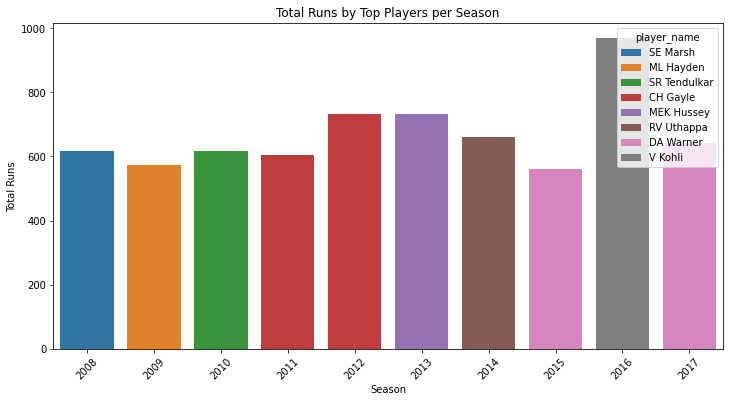

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(x="season", y="total_runs", hue="player_name", data=top_scoring_batsman_per_Season.toPandas(), dodge=False)

# Add labels and title
plt.xlabel("Season")
plt.ylabel("Total Runs")
plt.title("Total Runs by Top Players per Season")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()


#### Most economical bowler per season in powerplays (Which bowler gave least economy in powerplay)
economy = runs given / overs bowled
powerplay = 1-6 overs in every match

In [0]:
most_economical_bowler_per_Season = spark.sql("""
        select distinct player_name, b.season, economy   from             
(SELECT bowler, season, (sum(runs_scored+extra_runs)/(count(runs_scored)/6)) as economy,
             rank() over(partition by season order by (sum(runs_scored+extra_runs)/(count(runs_scored)/6)) )  as rnk
             from ball 
             where over_id <=6
             group by season, bowler
             order by season, rnk )b 
             join player_match pm
             on b.bowler = pm.player_id
             where rnk = 1
                        """) 
most_economical_bowler_per_Season.show()

+-------------+------+-----------------+
|  player_name|season|          economy|
+-------------+------+-----------------+
|   SC Ganguly|  2008|              3.0|
|   SM Harwood|  2009|2.210526315789474|
|    SB Jakati|  2010|              2.0|
|Harmeet Singh|  2011|              3.0|
|   AL Menaria|  2012|              2.0|
|    STR Binny|  2013|              1.0|
|    RA Jadeja|  2014|              1.0|
|   M de Lange|  2015|2.307692307692308|
|     MR Marsh|  2016|             2.75|
|   Ankit Soni|  2017|              3.0|
|   Avesh Khan|  2017|              3.0|
+-------------+------+-----------------+



##### over the years how different teams faired

In [0]:


team_wins_per_season = spark.sql("""
        select season_year, match_winner,count(match_winner) As number_of_match_wins from match
        where match_winner IN (
            select match_winner from match 
            GROUP BY match_winner
            having count(distinct(season_year)) >4
        )
        group by season_year, match_winner
        order by season_year, match_winner
                        """) 
team_wins_per_season.show(1000)

+-----------+--------------------+--------------------+
|season_year|        match_winner|number_of_match_wins|
+-----------+--------------------+--------------------+
|       2008| Chennai Super Kings|                   9|
|       2008|    Delhi Daredevils|                   7|
|       2008|     Kings XI Punjab|                  10|
|       2008|Kolkata Knight Ri...|                   6|
|       2008|      Mumbai Indians|                   7|
|       2008|    Rajasthan Royals|                  13|
|       2008|Royal Challengers...|                   4|
|       2008| Sunrisers Hyderabad|                   2|
|       2009| Chennai Super Kings|                   8|
|       2009|    Delhi Daredevils|                  10|
|       2009|     Kings XI Punjab|                   7|
|       2009|Kolkata Knight Ri...|                   3|
|       2009|      Mumbai Indians|                   5|
|       2009|    Rajasthan Royals|                   6|
|       2009|Royal Challengers...|              

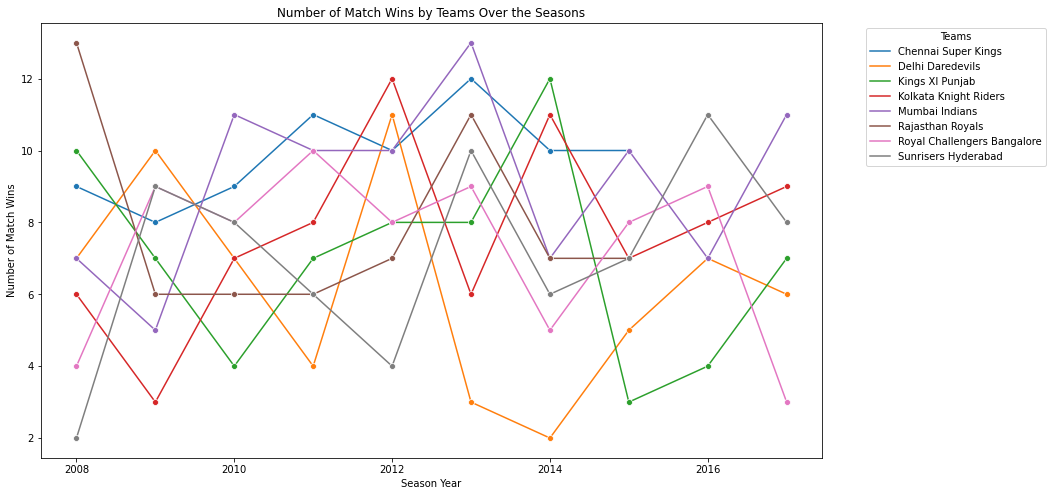

In [0]:
plt.figure(figsize=(14, 8))
team_wins_per_season = team_wins_per_season.filter((team_wins_per_season["match_winner"] != "tied") & (team_wins_per_season["match_winner"] != "abandoned") & (team_wins_per_season["match_winner"] != "NULL"))
# Create the line plot
sns.lineplot(data=team_wins_per_season.toPandas(), x="season_year", y="number_of_match_wins", hue="match_winner", marker="o")

# Add labels and title
plt.xlabel("Season Year")
plt.ylabel("Number of Match Wins")
plt.title("Number of Match Wins by Teams Over the Seasons")

# Show the legend
plt.legend(title="Teams", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()